In [15]:
import pandas as pd
import pandas_ta as ta # https://twopirllc.github.io/pandas-ta/
import numpy as np 
from scipy.stats import linregress # https://docs.scipy.org/doc/scipy/tutorial/index.html#user-guide
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # https://scikit-learn.org/stable/api/sklearn.html
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score 
from xgboost import XGBClassifier # https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
import joblib 

In [16]:
loaded_KNN_model = joblib.load('models/KNNmodel.sav')
loaded_XGB_model = joblib.load('models/XGBmodel.sav')

In [17]:
# Create a dataframe based on the csv file 
df = pd.read_csv("TrainingData/NVDA.USUSD_Candlestick_1_M_BID_16.01.2024-16.01.2025.csv")

# Drop zeroes from dataframe
indexZeroes = df[ df["volume"] == 0].index
df.drop(indexZeroes, inplace=True)
df.loc[(df["volume"] == 0)]

# Add Technical Indicators Using pandas ta
df['ATR'] = df.ta.atr(length=20) # Average True Range for 20 candlesticks
df['RSI'] = df.ta.rsi() # Relative Strength Index
df['Midpoint'] = df.ta.midprice(length=1) # Mid point of each candlestick
df['MA40'] = df.ta.sma(length=40) # Moving Average for 40 candlesticks
df['MA80'] = df.ta.sma(length=80) # Moving Average for 80 candlesticks
df['MA160'] = df.ta.sma(length=160) # Moving Average for 160 candlesticks

In [18]:
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_vale, p_value, std_err = linregress(x,y)
    return slope 

backrollingN = 6 # (5 previous showings and current)
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html
# .apply allows you to create and apply your own functions on a rolling window  
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Midpoint'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [19]:
# Define our targets 
pipdiff = 500*1e-5
SLTPRatio = 2 # pipdiff/Ratio gives Stop Lost

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length

    # Make sure these classifications are right
    for line in range(0, length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1, barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ((valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio))):
                trendcat[line] = 1 # downtrend
                break
            elif ((valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff)):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend

    return trendcat

df['mytarget'] = mytarget(16, df)

/tmp/ipykernel_71319/684101669.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax=ax)


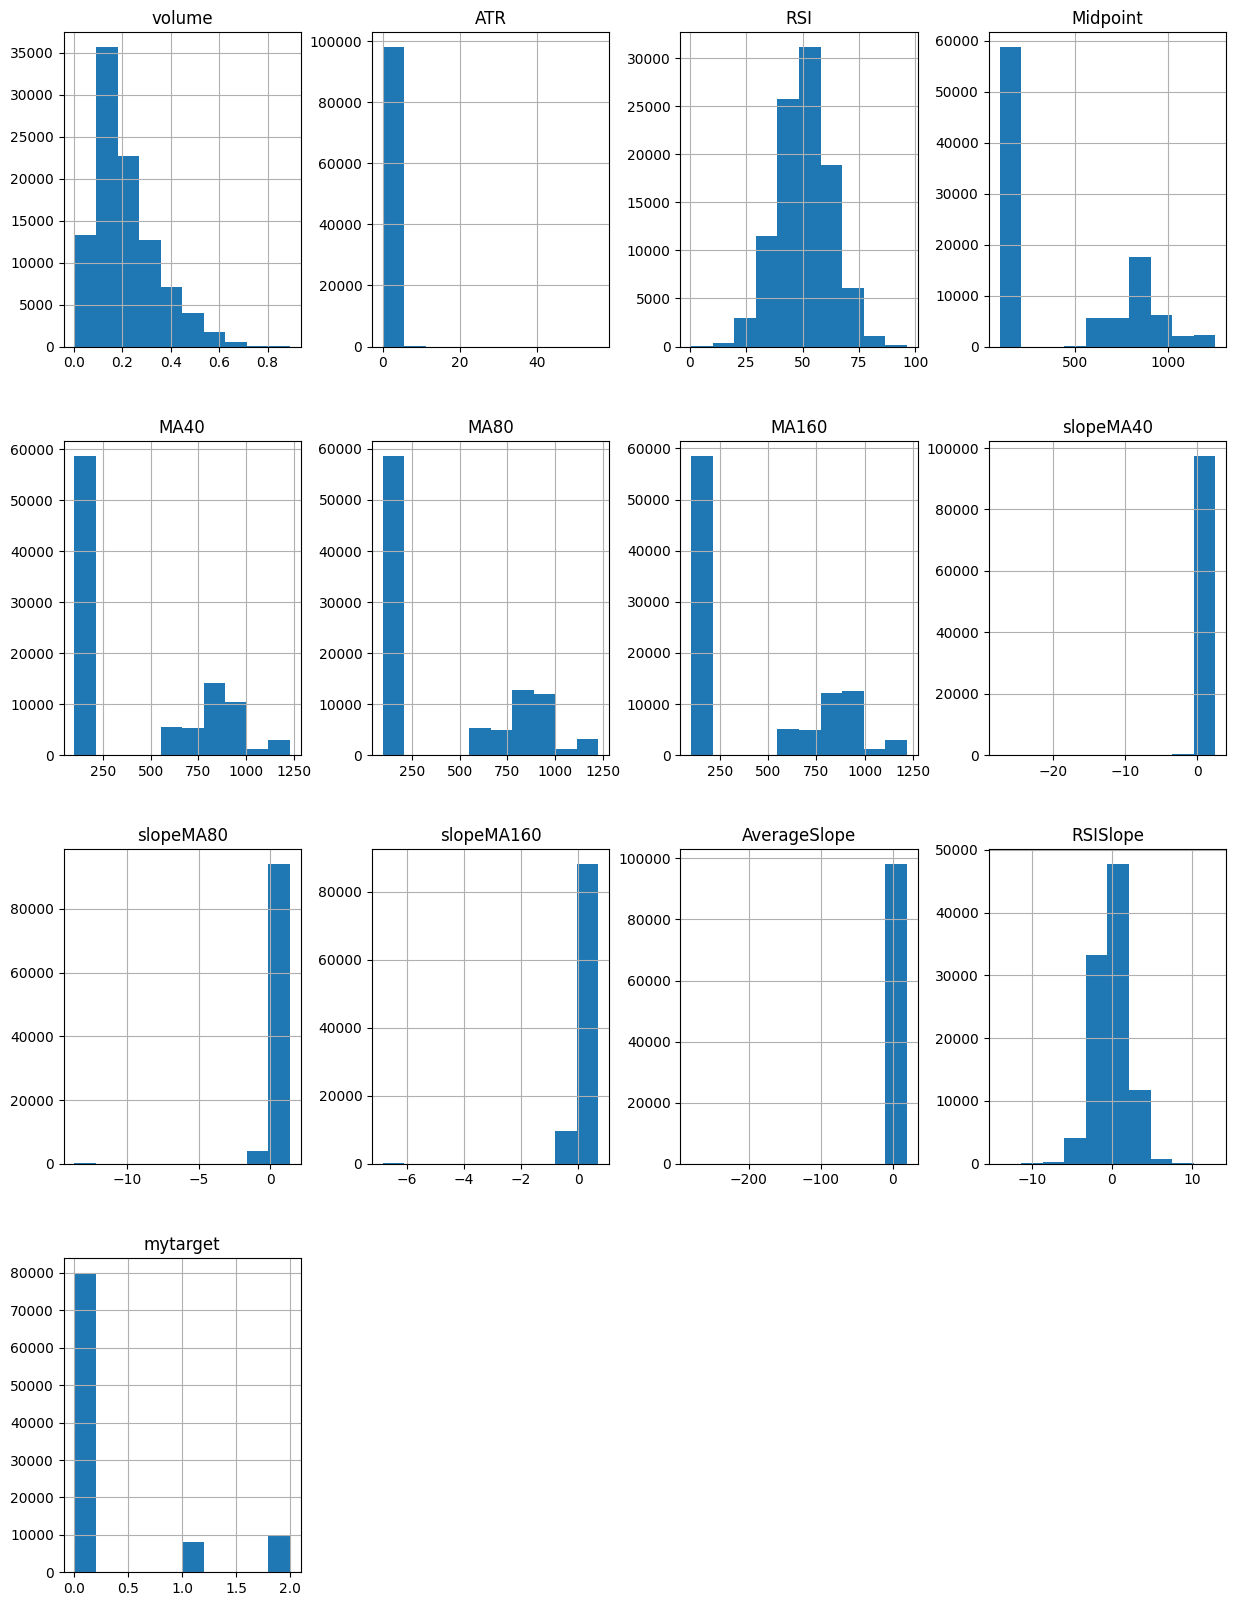

In [20]:
# Plot the data
fig = plt.figure(figsize=(15,20))
ax = fig.gca()
df_model = df[['volume', 'ATR', 'RSI', 'Midpoint', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']]
df_model.hist(ax=ax)
plt.show()

In [21]:
df_model = df_model.dropna()

attributes = ['ATR', 'RSI', 'Midpoint', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

             ATR        RSI  Midpoint        MA40        MA80       MA160  \
674     0.718072  47.903440  563.6715  564.727075  564.909975  561.969350   
675     0.712668  47.903440  563.4220  564.634325  564.880475  562.015850   
676     0.692080  48.924844  563.5665  564.546300  564.850350  562.053344   
677     0.688476  51.785446  563.7460  564.464825  564.827237  562.099094   
678     0.719607  42.401844  563.1810  564.376575  564.793725  562.142463   
...          ...        ...       ...         ...         ...         ...   
527917  0.136285  45.233165  135.0515  135.374600  135.343200  134.959081   
527918  0.136470  41.301707  135.0670  135.356100  135.341450  134.958025   
527919  0.133697  38.875825  134.9965  135.336875  135.339200  134.957713   
527920  0.131062  43.020610  134.9965  135.322600  135.339075  134.957081   
527921  0.137509  50.419323  135.1615  135.308875  135.340575  134.957587   

        slopeMA40  slopeMA80  slopeMA160  AverageSlope  RSISlope  
674     

In [9]:
# Split the data (arrays/dataframes) into training and testing subsets
# 20% testing and 80% training 
# Splits the data at random (should not do that for proper implementation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [22]:
# Sequential Sampling
# Splits the data into 80% training and 20% test sequentially 
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

In [23]:
# K Nearest Neighbors Model
KNNmodel = KNeighborsClassifier(n_neighbors=225, weights='uniform', algorithm='kd_tree',  leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
KNNmodel.fit(X_train, y_train)

y_pred_train = KNNmodel.predict(X_train)
y_pred_test = KNNmodel.predict(X_test)

In [24]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))
print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

Accuracy train: 81.25%
Accuracy test: 82.83%
mytarget
0.0    81.568567
2.0    10.290211
1.0     8.141222
Name: count, dtype: float64


In [25]:
#sequential sampling
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

# XGBoost Model
XGmodel = XGBClassifier()
XGmodel.fit(X_train, y_train)
XGpred_train = XGmodel.predict(X_train)
XGpred_test = XGmodel.predict(X_test)
XGaccuracy_train = accuracy_score(y_train, XGpred_train)
XGaccuracy_test = accuracy_score(y_test, XGpred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(XGaccuracy_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(XGaccuracy_test))

****Train Results****
Accuracy: 81.6702%
****Test Results****
Accuracy: 82.7458%


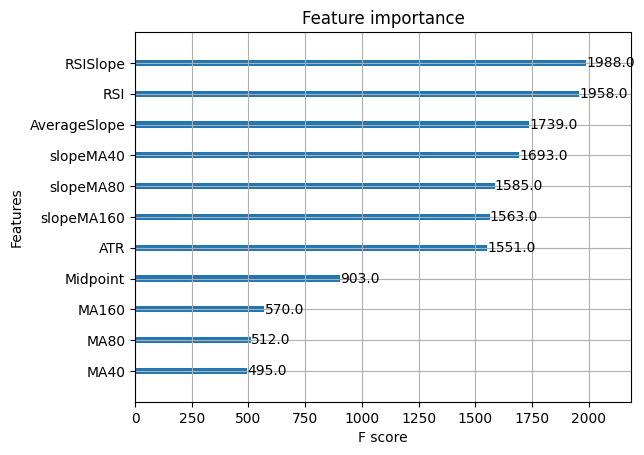

In [29]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(XGmodel)
pyplot.show()

In [30]:
import joblib 

# Save KNN model
KNNfile = 'models/KNNmodel.sav'
joblib.dump(KNNmodel, KNNfile)

# Save XGB model
XGfile = 'models/XGBmodel.sav'
joblib.dump(XGmodel, XGfile)

# Load models
loaded_KNN_model = joblib.load('models/KNNmodel.sav')
loaded_XGB_model = joblib.load('models/XGBmodel.sav')

In [38]:
import smtplib
import json
import os

# Should use environment variables for this 
gmail_user = os.environ.get('robinhood_username')
gmail_password = os.environ.get("gmail_password")
sent_from = gmail_user
to = [gmail_user]
subject = "Trading"
print(gmail_user, gmail_password)

None None


In [31]:
from apscheduler.schedulers.blocking import BlockingScheduler # https://apscheduler.readthedocs.io/en/3.x/userguide.html
import json
import os
# Oanda
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails

# Alpaca
import alpaca as al
from alpaca.trading.client import TradingClient as alTradingClient
from alpaca.trading.enums import OrderSide as alOrderSide
from alpaca.trading.enums import TimeInForce as alTimeInForce
from alpaca.trading.requests import MarketOrderRequest as alMarketOrderRequest
from alpaca.data.timeframe import TimeFrame as alTimeFrame
from alpaca.data.timeframe import TimeFrameUnit as alTimeFrameUnit
from alpaca.data.models import Bar as alBar
from alpaca.data.requests import StockBarsRequest as alStockBarsRequest
from alpaca.data.requests import StockLatestBarRequest as alStockLatestBarRequest
from alpaca.data.historical import StockHistoricalDataClient
from datetime import datetime
from datetime import timedelta

In [33]:
ModelPrediction = 0
def call_alpaca():
    alpaca_key = "PK61HVAVN7MBAD6DXCZ1"
    alpaca_secret = "C07ugBdCNQDDevPvg2vGQ6mkZP63hCpdeJchE5os"
    alClient = alTradingClient(api_key=alpaca_key,secret_key=alpaca_secret, paper=True)
    historical_client = StockHistoricalDataClient(api_key=alpaca_key, secret_key=alpaca_secret, raw_data=True)
    # alClient = alTradingClient(api_key=os.environ.get("alpaca_API"), secret_key=os.environ.get("alpaca_SecretKey"), paper=True)
    symbol_ = "NVDA"

    dfstream = pd.DataFrame(columns=['Open', 'Close', 'High', 'Low'])

    time_frame = alTimeFrame(amount=5, unit=alTimeFrameUnit.Minute)
    start_time = datetime.now() - timedelta(hours=22)

    previous_180_bars_request_params = alStockBarsRequest(symbol_or_symbols=symbol_, timeframe=time_frame, limit=180, start=start_time, end=(datetime.now()))
    previous_180_bars = historical_client.get_stock_bars(previous_180_bars_request_params)

    dfstream = pd.DataFrame(columns=['Open', 'Close', 'High', 'Low'])
    iterator = 0
    for bar in previous_180_bars[symbol_]:
        dfstream.loc[iterator, ['Open']] = float(str(bar['o']))
        dfstream.loc[iterator, ['Close']] = float(str(bar['c']))
        dfstream.loc[iterator, ['High']] = float(str(bar['h']))
        dfstream.loc[iterator, ['Low']] = float(str(bar['l']))
        iterator+=1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)
    # Set TA
    dfstream['ATR'] = dfstream.ta.atr(length=20) 
    dfstream['RSI'] = dfstream.ta.rsi()
    dfstream['Midpoint'] = dfstream.ta.midprice(length=1)
    dfstream['MA40'] = dfstream.ta.sma(length=40)
    dfstream['MA80'] = dfstream.ta.sma(length=80)
    dfstream['MA160'] = dfstream.ta.sma(length=160)   
    # Calculate Slopes
    backrollingN = 6
    dfstream['slopeMA40'] = dfstream['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA80'] = dfstream['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['slopeMA160'] = dfstream['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['AverageSlope'] = dfstream['Midpoint'].rolling(window=backrollingN).apply(get_slope, raw=True)
    dfstream['RSISlope'] = dfstream['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

    attributes = ['ATR', 'RSI', 'Midpoint', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
    # X_stream is 167 candles
    X_stream = dfstream.iloc[[167]]
    X_model = X_stream[attributes]

    ModelPrediction = loaded_KNN_model.predict(X_model)
    ModelPredictionmsg = str(ModelPrediction)

    bar_request_params = alStockLatestBarRequest(symbol_or_symbols=symbol_)
    latest_bar = historical_client.get_stock_latest_bar(bar_request_params)

    pipdiff = 500*1e-5 # Take Profit
    SLTPRatio = 2 # Every winning trade makes up for 2 losing trades

    # I don't understand these metrics too well because they're for 2 different scenarios of shorting or longing
    TPBuy = float(str(latest_bar[symbol_]['o']))+pipdiff
    SLBuy = float(str(latest_bar[symbol_]['o']))-(pipdiff/SLTPRatio)
    TPSell = float(str(latest_bar[symbol_]['o']))-pipdiff
    SLSell = float(str(latest_bar[symbol_]['o']))+(pipdiff/SLTPRatio)

    time = alTimeInForce.DAY

    # Sell Case
    if ModelPrediction == 0:
        print(ModelPredictionmsg)
    elif ModelPrediction == 1:
        alSell = alMarketOrderRequest(symbol=symbol_, side=alOrderSide.SELL, notional=5, take_profit=TPSell, stop_loss=SLSell, time_in_force=time)
        Order = alClient.submit_order(order_data=alSell)
        print(Order)
    # Buy Case 
    elif ModelPrediction == 2:
        alBuy = alMarketOrderRequest(symbol=symbol_, side=alOrderSide.BUY, notional=5, take_profit=TPBuy, stop_loss=SLBuy, time_in_force=time)
        Order = alClient.submit_order(order_data=alBuy)
        print(Order)
    

In [35]:
scheduler = BlockingScheduler(job_defaults={'misfire_grace_time': 2*60}) # 2 min gracetime for misfires
scheduler.add_job(call_alpaca, 'cron', day_of_week='mon-fri', minute="*/5", jitter=60)
scheduler.start()

KeyboardInterrupt: 